# Analysis of Clonesig results on the PCAWG


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
import os
from statsmodels.stats.multitest import multipletests
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import collections
from scipy.stats import chi2_contingency
from lifelines import CoxPHFitter
from pathlib import Path

pd.options.display.max_columns = 200
os.chdir('..')
output_path = '20200515_paper_figures/PCAWG_results'
Path(output_path).mkdir(parents=True, exist_ok=True)
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
clonesig_res = pd.read_csv('20200514_pcawg_results.csv', sep='\t')


In [4]:
clonesig_res.head()

,patient_id,mutation_set,prop_diploid,ploidy,purity,nb_mut,nb_sigs,nb_sigs_prefit,major_cn_mean,total_cn_mean,method,prefit_bool,sigprofiler_bool,dof,nb_clones,lr,pval,clonal_phi,clonal_xi,nb_mut_clonal,largest_subclonal_phi,largest_subclonal_xi,nb_mut_largest_subclonal,clonal_largest_sub_pidist,largest_pi_dist,overall_profile_dist,runtime,clonal_SBS1,clonal_SBS2,clonal_SBS3,clonal_SBS4,clonal_SBS5,clonal_SBS6,clonal_SBS7a,clonal_SBS7b,clonal_SBS7c,clonal_SBS7d,clonal_SBS8,clonal_SBS9,clonal_SBS10a,clonal_SBS10b,clonal_SBS11,clonal_SBS12,clonal_SBS13,clonal_SBS14,clonal_SBS15,clonal_SBS16,clonal_SBS17a,clonal_SBS17b,clonal_SBS18,clonal_SBS19,clonal_SBS20,clonal_SBS21,clonal_SBS22,clonal_SBS23,clonal_SBS24,clonal_SBS25,clonal_SBS26,clonal_SBS27,clonal_SBS28,clonal_SBS29,clonal_SBS30,clonal_SBS31,clonal_SBS32,clonal_SBS33,clonal_SBS34,clonal_SBS35,clonal_SBS36,clonal_SBS37,clonal_SBS38,clonal_SBS39,clonal_SBS40,clonal_SBS41,clonal_SBS42,clonal_SBS43,clonal_SBS44,clonal_SBS45,clonal_SBS46,clonal_SBS47,clonal_SBS48,clonal_SBS49,clonal_SBS50,clonal_SBS51,clonal_SBS52,clonal_SBS53,clonal_SBS54,clonal_SBS55,clonal_SBS56,clonal_SBS57,clonal_SBS58,clonal_SBS59,clonal_SBS60,subclonal_SBS1,subclonal_SBS2,subclonal_SBS3,subclonal_SBS4,subclonal_SBS5,subclonal_SBS6,subclonal_SBS7a,subclonal_SBS7b,subclonal_SBS7c,subclonal_SBS7d,subclonal_SBS8,subclonal_SBS9,subclonal_SBS10a,subclonal_SBS10b,subclonal_SBS11,subclonal_SBS12,subclonal_SBS13,subclonal_SBS14,subclonal_SBS15,subclonal_SBS16,subclonal_SBS17a,subclonal_SBS17b,subclonal_SBS18,subclonal_SBS19,subclonal_SBS20,subclonal_SBS21,subclonal_SBS22,subclonal_SBS23,subclonal_SBS24,subclonal_SBS25,subclonal_SBS26,subclonal_SBS27,subclonal_SBS28,subclonal_SBS29,subclonal_SBS30,subclonal_SBS31,subclonal_SBS32,subclonal_SBS33,subclonal_SBS34,subclonal_SBS35,subclonal_SBS36,subclonal_SBS37,subclonal_SBS38,subclonal_SBS39,subclonal_SBS40,subclonal_SBS41,subclonal_SBS42,subclonal_SBS43,subclonal_SBS44,subclonal_SBS45,subclonal_SBS46,subclonal_SBS47,subclonal_SBS48,subclonal_SBS49,subclonal_SBS50,subclonal_SBS51,subclonal_SBS52,subclonal_SBS53,subclonal_SBS54,subclonal_SBS55,subclonal_SBS56,subclonal_SBS57,subclonal_SBS58,subclonal_SBS59,subclonal_SBS60
0,51800588-c622-11e3-bf01-24c6515278c0,Liver-HCC,0.753945,1.969,0.810,6084,23,23,1.166831,2.085470,clonesig,False,False,10,2,50.025929,7.019449e-06,0.999990,0.940406,5748,0.292676,0.059594,336.0,0.104330,0.104330,0.020513,698.621623,2.633318e-02,NaN,0.057853,0.111823,0.108147,1.154489e-02,NaN,NaN,NaN,NaN,NaN,0.000192,NaN,NaN,NaN,0.071963,NaN,0.002905,NaN,1.087669e-01,0.003846,0.002640,0.029013,0.042770,NaN,NaN,0.033576,7.890721e-10,0.000658,NaN,0.029217,NaN,1.838956e-12,0.004082,0.030186,0.000003,NaN,NaN,NaN,0.007688,NaN,NaN,NaN,NaN,0.316796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011209,NaN,0.002468,0.022315,0.002786,0.047770,NaN,NaN,NaN,NaN,NaN,3.439644e-02,NaN,NaN,NaN,0.098707,NaN,0.039727,NaN,2.351811e-03,2.588233e-03,1.357951e-03,1.328654e-01,3.097663e-10,NaN,NaN,0.067038,3.841551e-11,0.004168,NaN,2.273969e-08,NaN,7.141651e-04,0.046202,0.192424,0.000002,NaN,NaN,NaN,0.010036,NaN,NaN,NaN,NaN,0.280874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2bd56bba-c623-11e3-bf01-24c6515278c0,Liver-HCC,0.702204,1.714,0.218,7485,23,23,1.086974,1.876687,clonesig,False,False,10,1,0.044281,1.000000e+00,0.999990,1.000000,7485,NaN,NaN,NaN,NaN,0.000000,0.026621,238.520155,6.857202e-18,NaN,0.004136,0.024323,0.004018,7.225259e-09,NaN,NaN,NaN,NaN,NaN,0.006221,NaN,NaN,NaN,0.105194,NaN,0.004678,NaN,7.539424e-03,0.002282,0.000001,0.048695,0.012235,NaN,NaN,0.082219,3.597481e-06,0.244275,NaN,0.000507,NaN,5.028361e-16,0.154126,0.015913,0.000002,NaN,NaN,NaN,0.000271,NaN,NaN,NaN,NaN,0.283363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
clonesig_res.mutation_set.value_counts()

Liver-HCC          268
Prost-AdenoCA      260
Panc-AdenoCA       233
CNS-Medullo        145
Breast             109
Eso-AdenoCA         97
Lymph-BNHL          94
Lymph-CLL           92
CNS-PiloAstro       89
Panc-Endocrine      82
BRCA                79
Kidney-RCC          67
Skin-Melanoma       65
Ovary-AdenoCA       64
COADREAD            56
Myeloid-MDS/MPN     54
LIHC                51
THCA                48
LUSC                48
KICH                45
UCEC                44
HNSC                40
OV                  39
Bone-Osteosarc      37
Stomach-AdenoCA     36
KIRC                34
STAD                34
SKCM                34
KIRP                33
LUAD                31
Biliary-AdenoCA     30
GBM                 29
SARC                27
Bone-Other          26
BLCA                22
PRAD                19
LGG                 18
CESC                18
Myeloid-AML         16
Head-SCC            12
DLBC                 7
Name: mutation_set, dtype: int64

In [6]:
match_cohort = {'BRCA': 'Breast', 'COADREAD': 'ColoRect-AdenoCA',
                'LIHC': 'Liver-HCC', 'THCA': 'Thy-AdenoCA',
                'LUSC': 'Lung-SCC', 'KICH': 'Kidney-ChRCC',
                'UCEC': 'Uterus-AdenoCA', 'HNSC': 'Head-SCC',
                'OV': 'Ovary-AdenoCA', 'KIRC': 'Kidney-RCC',
                'SKCM': 'Skin-Melanoma', 'STAD': 'Stomach-AdenoCA',
                'KIRP': 'Kidney-PRCC', 'LUAD': 'Lung-AdenoCA',
                'GBM': 'CNS-GBM', 'SARC': 'Bone-Leiomyo',
                'BLCA': 'Bladder-TCC', 'PRAD': 'Prost-AdenoCA',
                'CESC': 'Cervix-SCC', 'LGG': 'CNS-Oligo',
                'DLBC': 'Lymph-BNHL'}

clonesig_res = clonesig_res.assign(new_mutation_set=clonesig_res.apply(lambda x: match_cohort[x['mutation_set']] if x['mutation_set'] in match_cohort else x['mutation_set'], axis=1))

clonesig_res.new_mutation_set.value_counts()


Liver-HCC           319
Prost-AdenoCA       279
Panc-AdenoCA        233
Breast              188
CNS-Medullo         145
Ovary-AdenoCA       103
Lymph-BNHL          101
Kidney-RCC          101
Skin-Melanoma        99
Eso-AdenoCA          97
Lymph-CLL            92
CNS-PiloAstro        89
Panc-Endocrine       82
Stomach-AdenoCA      70
ColoRect-AdenoCA     56
Myeloid-MDS/MPN      54
Head-SCC             52
Thy-AdenoCA          48
Lung-SCC             48
Kidney-ChRCC         45
Uterus-AdenoCA       44
Bone-Osteosarc       37
Kidney-PRCC          33
Lung-AdenoCA         31
Biliary-AdenoCA      30
CNS-GBM              29
Bone-Leiomyo         27
Bone-Other           26
Bladder-TCC          22
CNS-Oligo            18
Cervix-SCC           18
Myeloid-AML          16
Name: new_mutation_set, dtype: int64

In [7]:
clonesig_res.patient_id.nunique()

2632

In [8]:
clonesig_res.new_mutation_set.nunique()

32

Liver-HCC
Eso-AdenoCA
Prost-AdenoCA
Panc-AdenoCA
CNS-Medullo
Ovary-AdenoCA
Lymph-BNHL
Myeloid-MDS/MPN
Bone-Osteosarc
Breast
Stomach-AdenoCA
Bone-Other
Kidney-RCC
CNS-PiloAstro
Lymph-CLL
Panc-Endocrine
Biliary-AdenoCA
Skin-Melanoma
Myeloid-AML
Head-SCC
Kidney-ChRCC
Bone-Leiomyo
Thy-AdenoCA
Uterus-AdenoCA
Lung-SCC
CNS-GBM
Bladder-TCC
CNS-Oligo
Lung-AdenoCA
Cervix-SCC
Kidney-PRCC
ColoRect-AdenoCA


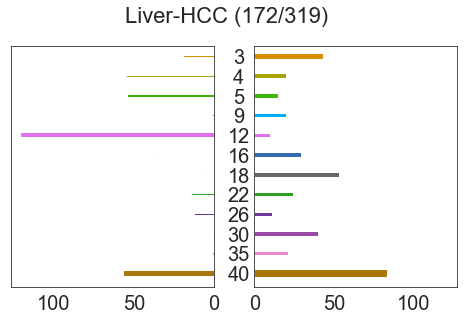

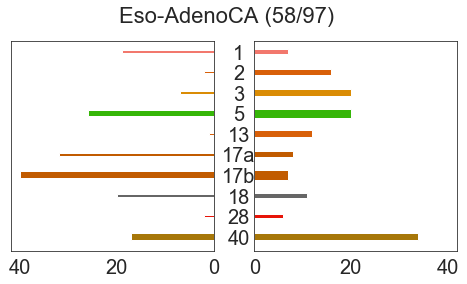

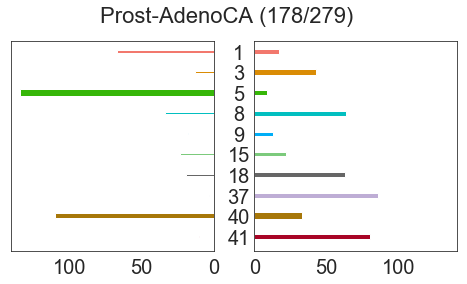

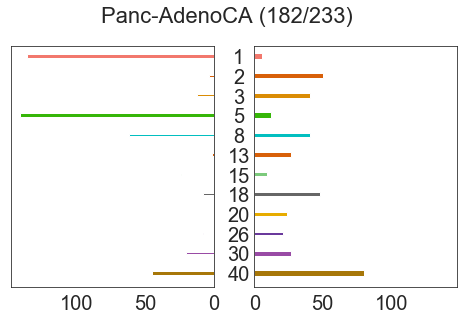

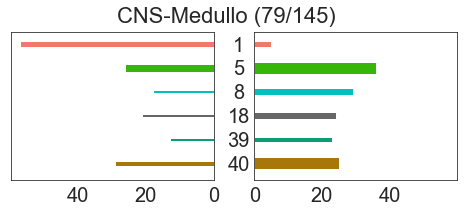

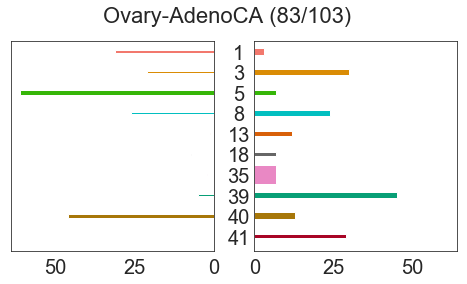

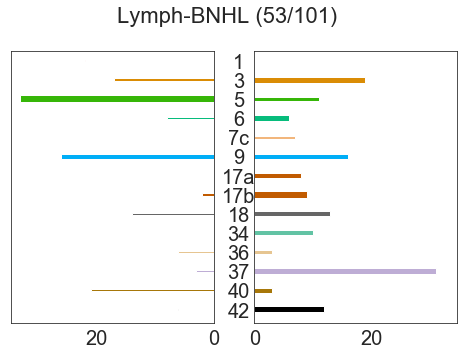

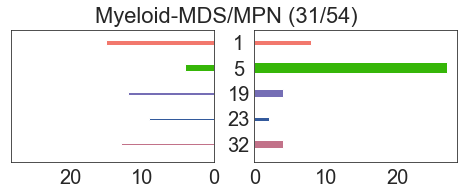

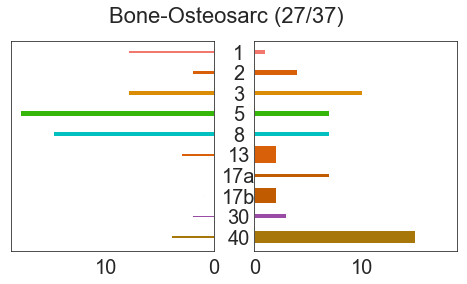

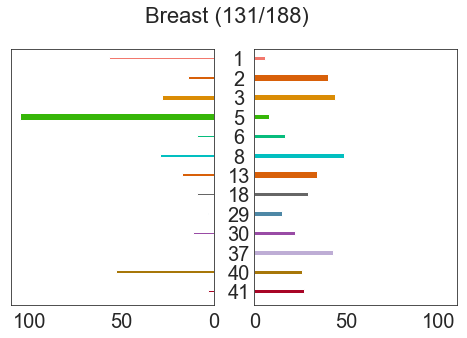

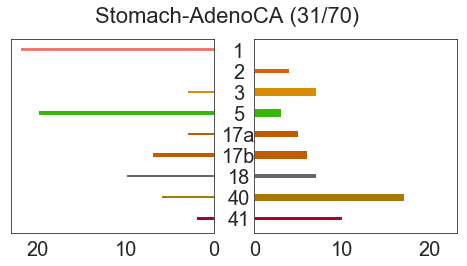

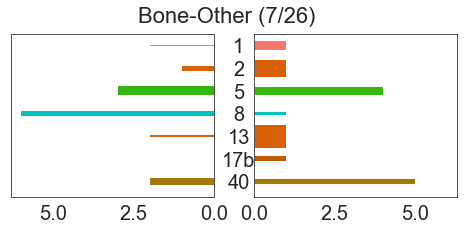

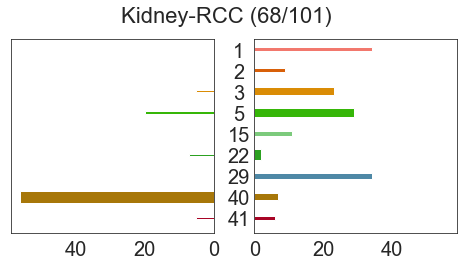

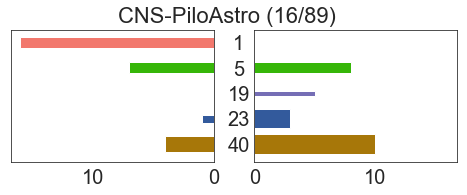

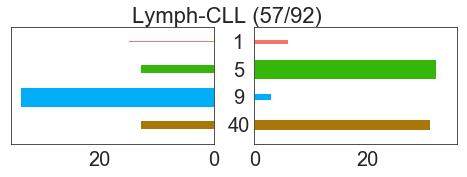

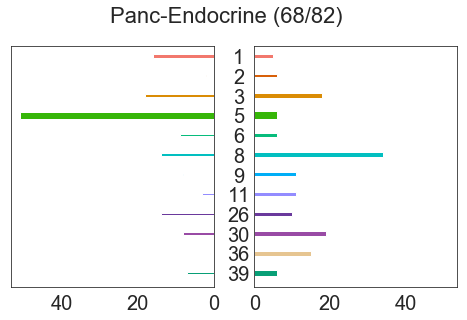

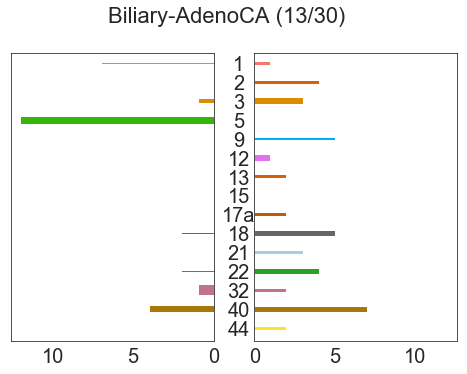

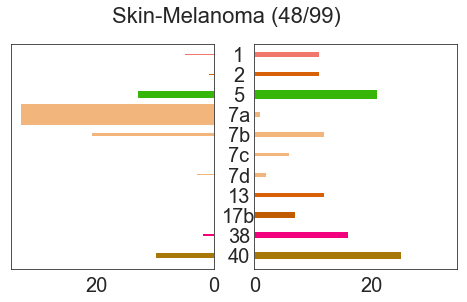

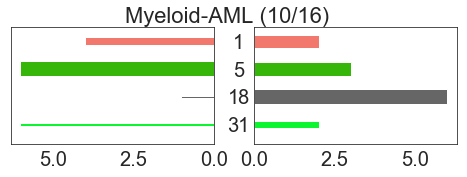

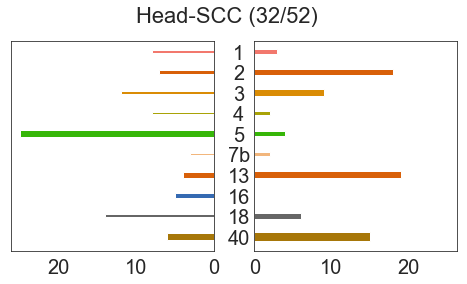

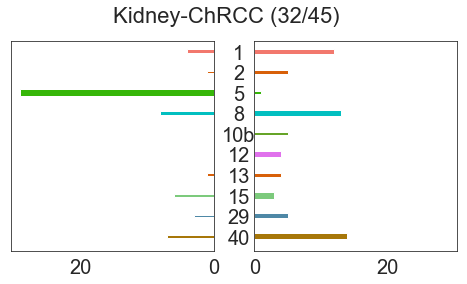

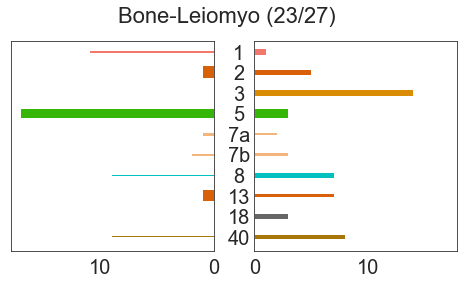

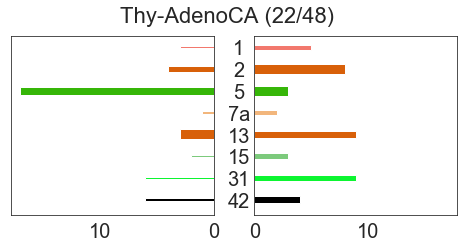

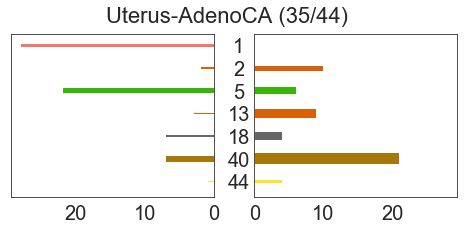

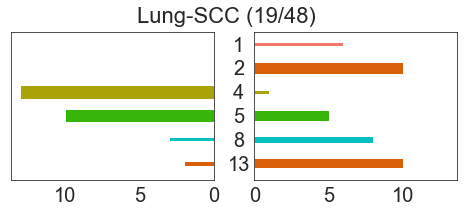

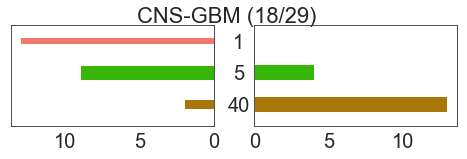

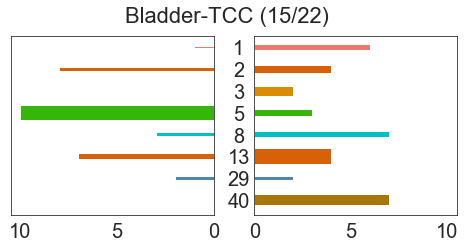

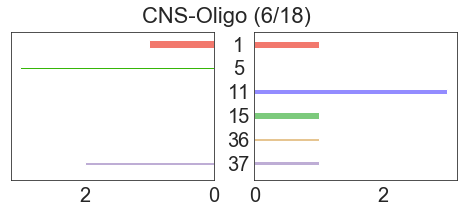

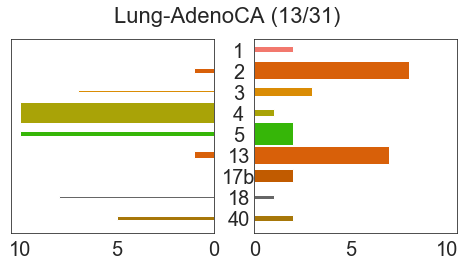

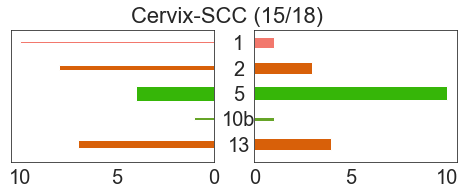

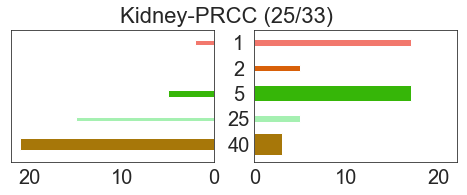

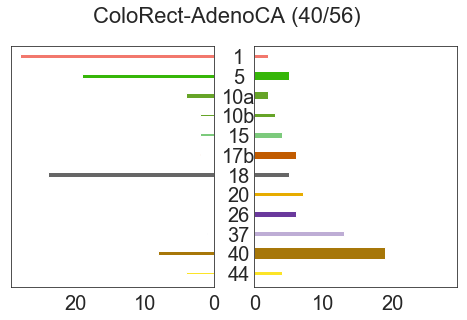

In [9]:
color_dict = collections.OrderedDict()
color_dict['SBS1']= '#F2786D'
color_dict['SBS2']= '#D86009'
color_dict['SBS13']= '#D86009'
color_dict['SBS3']= '#DA8C05'
color_dict['SBS4']= '#A9A307'
color_dict['SBS5']= '#36B608'
color_dict['SBS6']= '#07BC7C'
color_dict['SBS7a']= '#f2b67c'
color_dict['SBS7b']= '#f2b67c'
color_dict['SBS7c']= '#f2b67c'
color_dict['SBS7d']= '#f2b67c'
color_dict['SBS8']= '#02BFC0'
color_dict['SBS9']= '#00AEF7'
color_dict['SBS10a']= '#66A428'
color_dict['SBS10b']= '#66A428'
color_dict['SBS11']= '#938CFF'
color_dict['SBS12']= '#E071EC'
color_dict['SBS14']= '#F566BE'
color_dict['SBS15']= '#7CCA7C'
color_dict['SBS16']= '#356AB2'
color_dict['SBS17a']= '#C15B00'
color_dict['SBS17b']= '#C15B00'
color_dict['SBS18']= '#666666'
color_dict['SBS19']= '#756EB5'
color_dict['SBS20']= '#E7AC00'
color_dict['SBS21']= '#A5CEE4'
color_dict['SBS22']= '#2CA121'
color_dict['SBS23']= '#335a9c'
color_dict['SBS24']= '#FEC068'
color_dict['SBS25']= '#a5f0b1'
color_dict['SBS26']= '#6A399C'
color_dict['SBS28']= '#E71408'
color_dict['SBS29']= '#4e88a6'
color_dict['SBS30']= '#994BA5'
color_dict['SBS31']= '#0cf531'
color_dict['SBS33']= '#A75620'
color_dict['SBS34']= '#62C3A4'
color_dict['SBS35']= '#E988C4'
color_dict['SBS36']= '#E6C591'
color_dict['SBS37']= '#BEADD5'
color_dict['SBS38']= '#F3007E'
color_dict['SBS39']= '#089F76'
color_dict['SBS40']= '#A77709'
color_dict['SBS41']= '#a80526'
color_dict['SBS42']= 'black'
color_dict['SBS43']= '#6b088a'
color_dict['SBS44']= '#fce428'
color_dict['SBS45']= '#f0d0f2'
color_dict['SBS46']= '#78aaff'
color_dict['SBS47']= '#ffb108'
color_dict['SBS49']= '#c108ff'
color_dict['SBS32']= '#c27289'
color_dict['SBS54']= '#1320d1'
color_dict['SBS56']= '#e8dba2'
color_dict['SBS58']= '#b0eb31'
color_dict['SBS59']= '#b8b8b8'

sns.set_style('white')
for loc in clonesig_res.new_mutation_set.unique():
    print(loc)
    sub_protected_chg = clonesig_res[(clonesig_res.pval<0.05) & (clonesig_res.new_mutation_set==loc)]#&(clonesig_res.nb_mut>200)&(clonesig_res.purity>0.4)]
    sbs_names = [c.split('_')[1] for c in sub_protected_chg if 'subclonal_SBS' in c]
    bla = pd.DataFrame(sub_protected_chg[[c for c in sub_protected_chg if 'subclonal_SBS' in c]].fillna(0).round(4).values - sub_protected_chg[[c for c in sub_protected_chg if ('clonal_SBS' in c) and ("sub" not in c)]].fillna(0).round(10).values, columns=sbs_names)

    final_table = bla[[c for i, c in enumerate(bla.columns) if np.abs(bla).sum(axis=0)[c]>0]]
    final_table[np.abs(final_table)<0.05] = 0
    final_table = final_table[[c for i, c in enumerate(final_table.columns) if np.abs(final_table!=0).sum(axis=0)[c]>0.1*len(final_table)]]
    (final_table>0).sum(axis=0)
    final_table = final_table[final_table.columns[::-1]]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, final_table.shape[1]/3.5+1))
    plt.subplots_adjust(wspace = 0.2)
    axes[1].barh(y=np.arange(final_table.shape[1]), width=(final_table>0).sum(axis=0).to_frame().T.values[0], color=[color_dict[c] for c in (final_table>0).sum(axis=0).to_frame().T.columns], height= final_table[final_table>0].median(axis=0)*2+0.05)
    axes[0].barh(y=np.arange(final_table.shape[1]), width=(final_table<0).sum(axis=0).to_frame().T.values[0], color=[color_dict[c] for c in (final_table<0).sum(axis=0).to_frame().T.columns],  height= final_table[final_table<0].median(axis=0)*2+0.05)
    axes[0].invert_xaxis()

    fig.suptitle('{} ({}/{})'.format(sub_protected_chg.new_mutation_set.unique()[0], len(sub_protected_chg), len(clonesig_res[(clonesig_res.new_mutation_set==loc)])), fontsize=22,y=1 + 0.05/final_table.shape[1])
    axes[1].set_yticks(range(len(final_table.columns)))
    axes[1].get_yaxis().set_tick_params(pad=12)
    axes[1].set_yticklabels([c.replace('SBS', '') for c in final_table.columns.tolist()], fontsize=20, ha='center')
    axes[0].set_ylim([-0.7, final_table.shape[1]-0.5])
    axes[1].set_ylim([-0.7, final_table.shape[1]-0.5])
    axes[0].set_yticks([])
    axes[1].tick_params(axis="x", labelsize=20)
    axes[0].tick_params(axis="x", labelsize=20)
    max_x = max([axes[1].get_xlim()[1], axes[0].get_xlim()[0]])
    axes[0].set_xlim([max_x, 0])
    axes[1].set_xlim([0, max_x])
    plt.savefig('{}/{}_sig_trend.pdf'.format(output_path, loc.replace('/', '_')), bbox_inches='tight')


Liver-HCC
Eso-AdenoCA
Prost-AdenoCA
Panc-AdenoCA
CNS-Medullo
Ovary-AdenoCA
Lymph-BNHL
Myeloid-MDS/MPN
Bone-Osteosarc
Breast
Stomach-AdenoCA
Bone-Other
Kidney-RCC
CNS-PiloAstro
Lymph-CLL
Panc-Endocrine
Biliary-AdenoCA
Skin-Melanoma
Myeloid-AML
Head-SCC
Kidney-ChRCC
Bone-Leiomyo
Thy-AdenoCA
Uterus-AdenoCA
Lung-SCC
CNS-GBM
Bladder-TCC
CNS-Oligo
Lung-AdenoCA
Cervix-SCC
Kidney-PRCC
ColoRect-AdenoCA


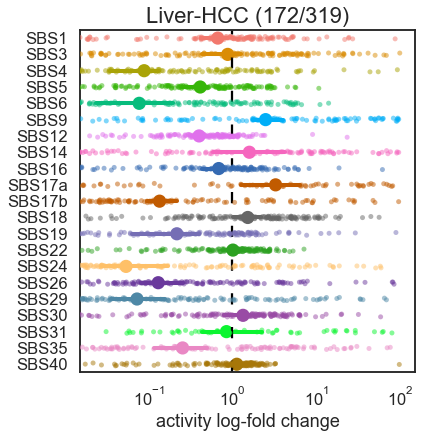

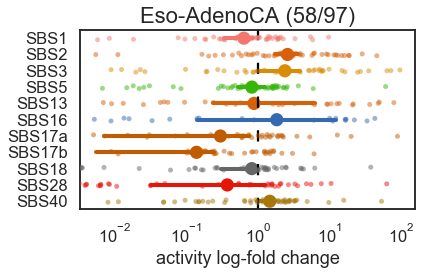

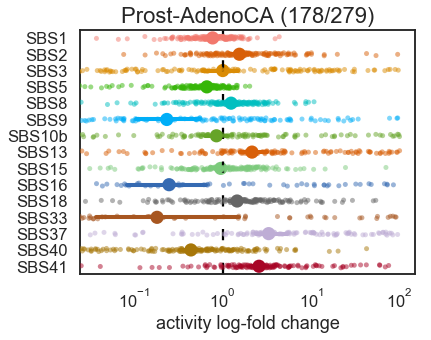

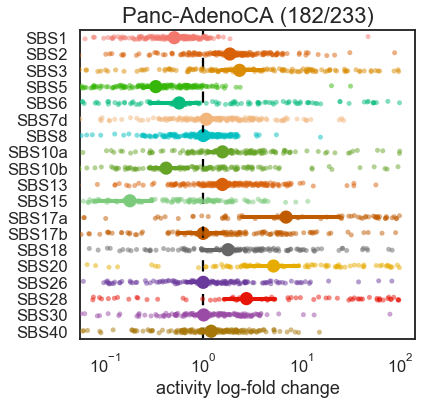

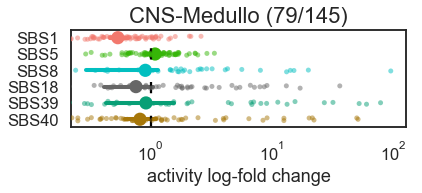

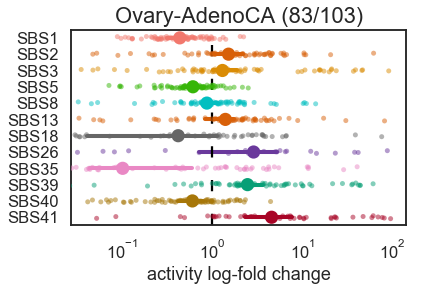

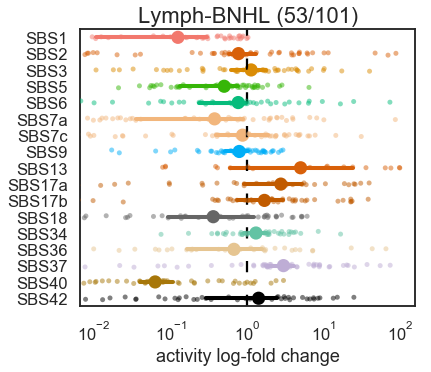

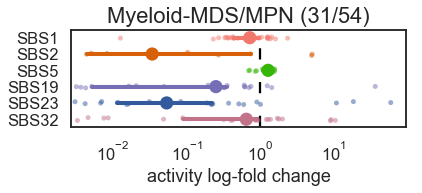

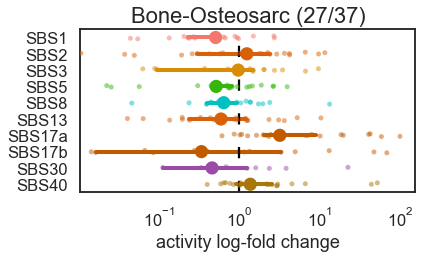

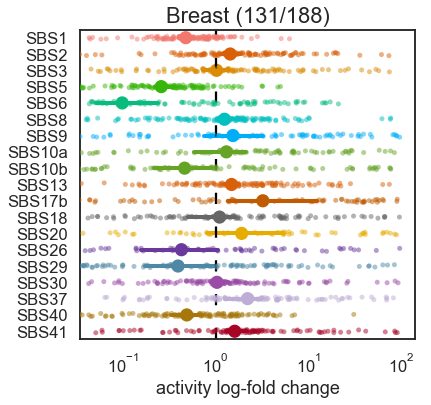

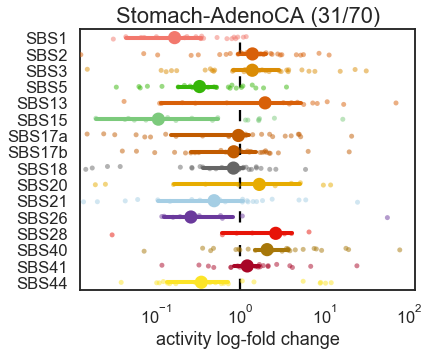

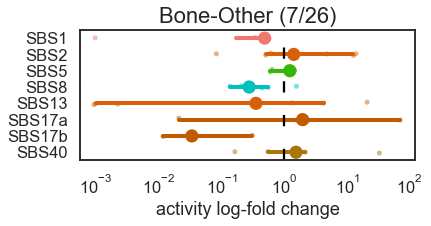

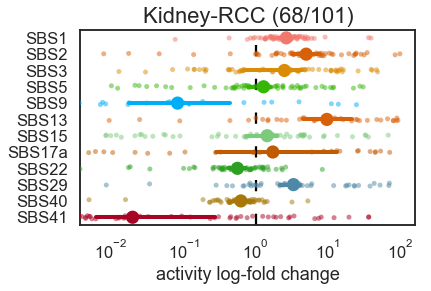

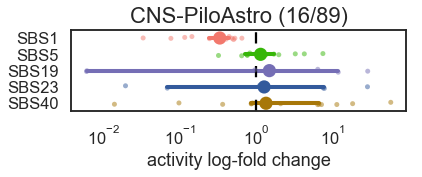

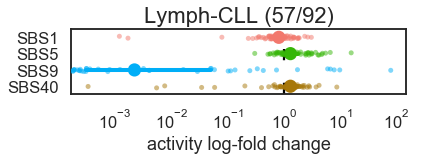

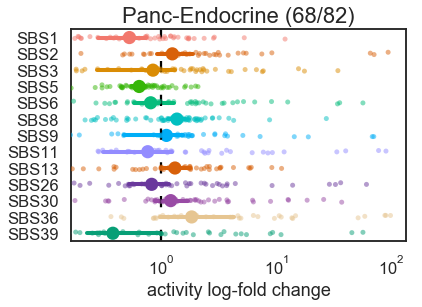

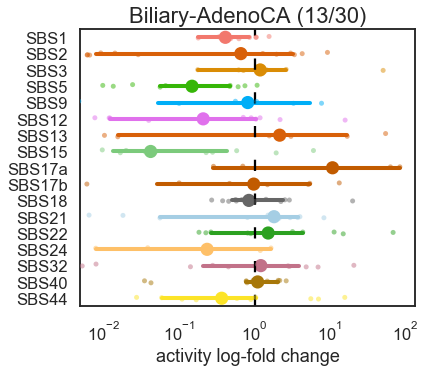

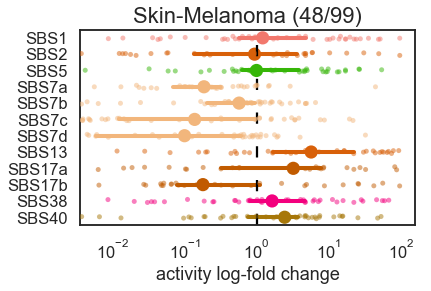

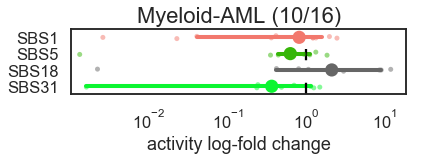

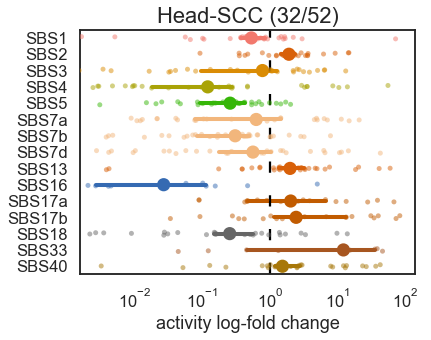

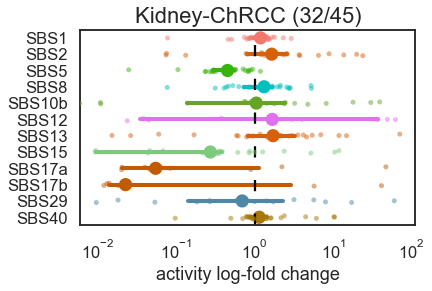

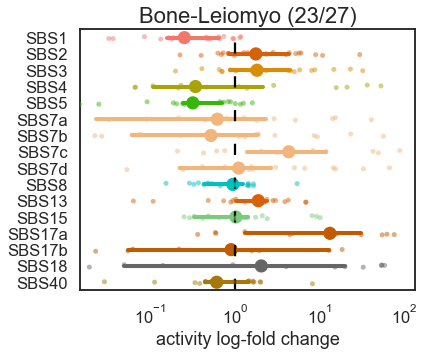

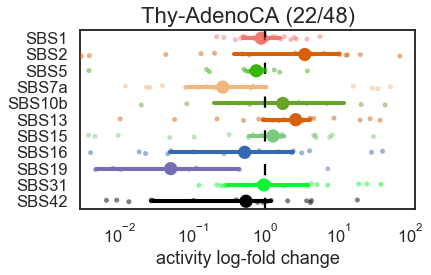

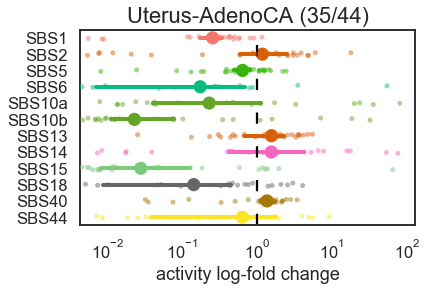

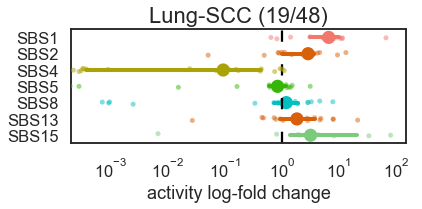

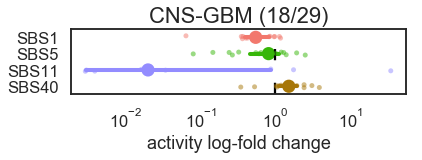

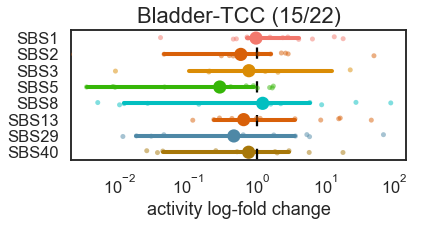

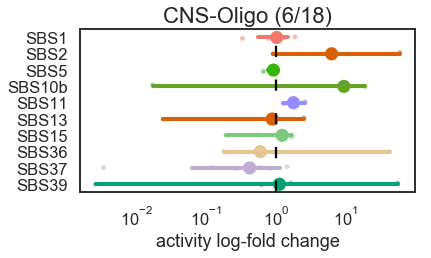

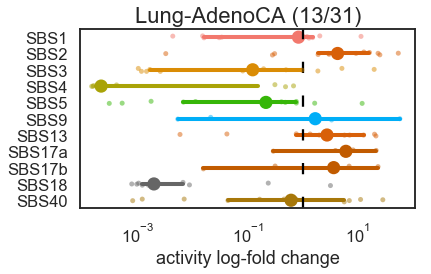

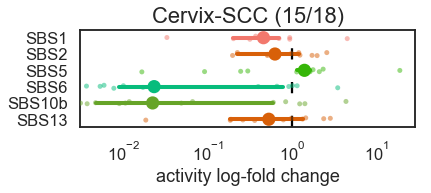

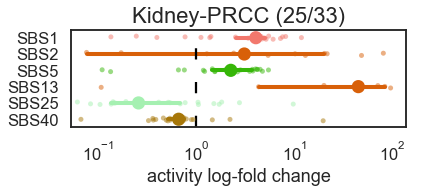

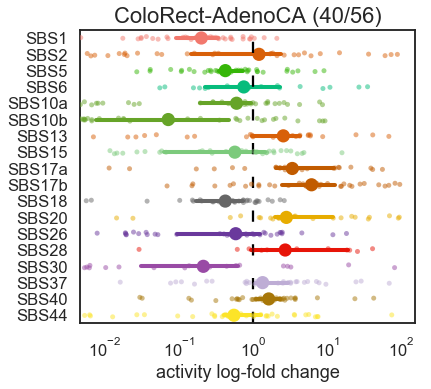

In [10]:

sns.set_context('talk')
sns.set_style('white')
for loc in clonesig_res.new_mutation_set.unique():
    print(loc)
    sub_protected_chg = clonesig_res[(clonesig_res.pval<0.05) & (clonesig_res.new_mutation_set==loc)]#&(clonesig_res.nb_mut>200)&(clonesig_res.purity>0.4)]
    sbs_names = [c.split('_')[1] for c in sub_protected_chg if 'subclonal_SBS' in c]
    for c in sub_protected_chg.columns:
        if 'subclonal_SBS' in c:
            sub_protected_chg = sub_protected_chg.assign(**{'{}_round'.format(c): sub_protected_chg.apply(lambda x: x[c] if x[c]>0.0001 else 0.0001 if x[c.replace("subclonal", "clonal")] > 0.0001 else 0, axis=1)})
        if ('clonal_SBS' in c) and ('subclonal_SBS' not in c):
            sub_protected_chg = sub_protected_chg.assign(**{'{}_round'.format(c): sub_protected_chg.apply(lambda x: x[c] if x[c]>0.0001 else 0.0001, axis=1)})
    bla = pd.DataFrame(sub_protected_chg[[c for c in sub_protected_chg if ('subclonal_SBS' in c) and  ('round' in c)]].fillna(0).values/sub_protected_chg[[c for c in sub_protected_chg if ('clonal_SBS' in c) and ("sub" not in c) and ("round" in c)]].fillna(0.001).values, columns=sbs_names)

    final_table = bla[[c for i, c in enumerate(bla.columns) if np.abs(bla).sum(axis=0)[c]>0]]
    m = pd.melt(final_table)
    m_filter = m[m.value<100]
    mm = m_filter[m_filter.value>0].groupby('variable').count()
    m_filter_mean = pd.merge(m_filter, mm, on='variable', suffixes=['', '_nonzero'])
    final_m = m_filter_mean[m_filter_mean.value_nonzero>(len(sub_protected_chg)/4)]
    fig, ax = plt.subplots(figsize=(6, 0.3*final_m.variable.nunique()))
    sns.stripplot(y='variable', x='value', data=final_m, ax=ax, palette=[color_dict[c] for c in final_m.variable.unique()], alpha=0.5)
    sns.pointplot(y='variable', x='value', data=final_m[final_m.value>0], ax=ax, palette=[color_dict[c] for c in final_m.variable.unique()], estimator=np.median)
    ax.set_xscale("log")
    ax.set_ylabel('')
    ax.set_xlabel('activity log-fold change')
    #ax.set_xlim([0.01, 100])
    ax.set_title('{} ({}/{})'.format(sub_protected_chg.new_mutation_set.unique()[0], len(sub_protected_chg), len(clonesig_res[(clonesig_res.new_mutation_set==loc)])), fontsize=22,y=1 + 0.05/final_table.shape[1])
    ax.axvline(x=1, ls=(0, (5, 10)), color='black')
    plt.savefig('{}/{}_sig_trend_new.pdf'.format(output_path, loc.replace('/', '_')), bbox_inches='tight')

Lung-AdenoCA


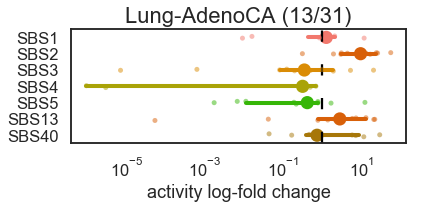

In [11]:
    loc = 'Lung-AdenoCA'
    print(loc)
    sub_protected_chg = clonesig_res[(clonesig_res.pval<0.05) & (clonesig_res.new_mutation_set==loc)]#&(clonesig_res.nb_mut>200)&(clonesig_res.purity>0.4)]
    sbs_names = [c.split('_')[1] for c in sub_protected_chg if 'subclonal_SBS' in c]
    for c in sub_protected_chg.columns:
        if 'subclonal_SBS' in c:
            sub_protected_chg = sub_protected_chg.assign(**{'{}_round'.format(c): sub_protected_chg.apply(lambda x: x[c] if x[c]>0.0000001 else 0, axis=1)})
        if ('clonal_SBS' in c) and ('subclonal_SBS' not in c):
            sub_protected_chg = sub_protected_chg.assign(**{'{}_round'.format(c): sub_protected_chg.apply(lambda x: x[c] if x[c]>10**-8 else 10**-8, axis=1)})
    bla = pd.DataFrame(sub_protected_chg[[c for c in sub_protected_chg if ('subclonal_SBS' in c) and  ('round' in c)]].fillna(0).values/sub_protected_chg[[c for c in sub_protected_chg if ('clonal_SBS' in c) and ("sub" not in c) and ("round" in c)]].fillna(0.001).values, columns=sbs_names)

    final_table = bla[[c for i, c in enumerate(bla.columns) if np.abs(bla).sum(axis=0)[c]>0]]
    m = pd.melt(final_table)
    m_filter = m[m.value<100]
    mm = m_filter[m_filter.value>0].groupby('variable').count()
    m_filter_mean = pd.merge(m_filter, mm, on='variable', suffixes=['', '_nonzero'])
    final_m = m_filter_mean[m_filter_mean.value_nonzero>(len(sub_protected_chg)/3)]
    fig, ax = plt.subplots(figsize=(6, 0.3*final_m.variable.nunique()))
    sns.stripplot(y='variable', x='value', data=final_m, ax=ax, palette=[color_dict[c] for c in final_m.variable.unique()], alpha=0.5)
    sns.pointplot(y='variable', x='value', data=final_m[final_m.value>0], ax=ax, palette=[color_dict[c] for c in final_m.variable.unique()], estimator=np.median)
    ax.set_xscale("log")
    ax.set_ylabel('')
    ax.set_xlabel('activity log-fold change')
    #ax.set_xlim([0.01, 100])
    ax.set_title('{} ({}/{})'.format(sub_protected_chg.new_mutation_set.unique()[0], len(sub_protected_chg), len(clonesig_res[(clonesig_res.new_mutation_set==loc)])), fontsize=22,y=1 + 0.05/final_table.shape[1])
    ax.axvline(x=1, ls=(0, (5, 10)), color='black')


In [12]:
m_filter_mean[m_filter_mean.variable=='SBS4']

,variable,value,value_nonzero
38,SBS4,0.000000e+00,5
39,SBS4,6.854223e-01,5
40,SBS4,2.961792e-06,5
41,SBS4,0.000000e+00,5
42,SBS4,0.000000e+00,5
43,SBS4,0.000000e+00,5
44,SBS4,3.134628e-01,5
45,SBS4,9.502018e-07,5
46,SBS4,0.000000e+00,5
47,SBS4,0.000000e+00,5


In [13]:
clonesig_res.patient_id.nunique()

2632

In [14]:
sum(clonesig_res.pval<0.05) / clonesig_res.patient_id.nunique()


0.6105623100303952